In [1]:
import sys
sys.path.append('../../')
import torch
import torch.nn as nn
import torch.optim as optim
from Code.envs.GPEnv import MultiEnv
from wip.Code.train_ac import make_dataset, backward_one
import time
from collections import OrderedDict

In [2]:

BATCH_SIZE = 512#64
SIM_TIME = 1
MAX_ITER = 10
USE_JIT = False

device = torch.device('cuda')

env = MultiEnv(BATCH_SIZE, MAX_ITER, device)

#torch.backends.cudnn.enabled = False


In [3]:
from Code.Networks import OuterWrapper
model = torch.load('../../models/rsnn_gppred4')
model_memory = model.layers.mem_loop.model.model

#model = OuterWrapper(model, device, USE_JIT)
model_memory = OuterWrapper(model_memory, device, USE_JIT, two_dim=True)

In [4]:
from Code.Networks import Selector, DynNetwork, OuterWrapper, LSTMWrapper, ReLuWrapper, DummyNeuron, make_SequenceWrapper
from Code.NewNeurons import SeqOnlySpike, CooldownNeuron

architecture = OrderedDict([
    ('input', 128),
    ('layer1', [['input'], ReLuWrapper(256), nn.Linear]),
    ('layer2', [['layer1'], ReLuWrapper(128), nn.Linear]),
    ('output', [['layer2'], DummyNeuron(1), nn.Linear]),
])


In [5]:
#144, 150, 137, 150

v_model = OuterWrapper(DynNetwork(architecture), device, USE_JIT)
p_model = OuterWrapper(DynNetwork(architecture), device, USE_JIT)

#model = (OuterWrapper(DynNetwork(architecturelstm), device, True))



In [11]:
params = list(v_model.parameters())+list(p_model.parameters())
optimizer = optim.Adam(params, lr=1e-4)#0.00001



In [12]:
def train_dataset(num_batches, num_epochs, var, gamma):
    obs, mem, value, advantage, actions, avg_reward = make_dataset(num_batches, BATCH_SIZE, MAX_ITER, v_model, p_model, model_memory, device, env, var, gamma)
    print('Avarage Reward: ', avg_reward)
    print('Action Variance: ', actions.var(0).mean())
    print('Avarage Start Value: ', value[0].mean())
    for e in range(num_epochs):
        start = time.time()
        idc = torch.randperm(num_batches*BATCH_SIZE*MAX_ITER, device=device)
        sum_v = 0
        sum_p = 0
        for i in range(num_batches*MAX_ITER):
            base = i*BATCH_SIZE
            batch_mem = mem.view(-1, 128)[idc[base:base + BATCH_SIZE]]
            batch_value = value.view(-1, 1)[idc[base:base + BATCH_SIZE]]
            batch_advantage = advantage.view(-1, 1)[idc[base:base + BATCH_SIZE]]
            batch_action = actions.view(-1, 1)[idc[base:base + BATCH_SIZE]]
            v_model.zero_grad()
            p_model.zero_grad()
            lossv, lossp = backward_one(batch_action, batch_mem, batch_value, batch_advantage, v_model, p_model, var, device)
            sum_v += lossv
            sum_p += lossp
            optimizer.step()
        for p in model.parameters():
            if torch.isnan(p).any():
                raise Exception('Corrupted Model')
        print(sum_v / (num_batches*MAX_ITER), sum_p / (num_batches*MAX_ITER), time.time()-start)
            #if i%10 == 0:
                #print(loss.item(), (loss/targets.view(-1).var()).item(), i)

In [13]:
for i in range(100):
    print('Bigstep: ', i)
    train_dataset(200, 5, 0.02, 1)
    #env.render()

Bigstep:  0
Avarage Reward:  tensor(1.0828, device='cuda:0')
Action Variance:  tensor(0.0660, device='cuda:0')
Avarage Start Value:  tensor(1.1360, device='cuda:0')
0.035056493073236196 -1.5977934591174126 13.914553880691528
0.03496322800125927 -1.615243112832308 13.910529375076294
0.034918297711759805 -1.620216102719307 13.869561195373535
0.03488223306136206 -1.6224966807067394 13.81372857093811
0.03484676702786237 -1.6246550298333169 13.958468198776245
Bigstep:  1
Avarage Reward:  tensor(1.1232, device='cuda:0')
Action Variance:  tensor(0.0798, device='cuda:0')
Avarage Start Value:  tensor(1.1416, device='cuda:0')
0.03774562927661464 -1.633888031333685 14.028120994567871
0.03766349939396605 -1.6376285515427589 14.448374032974243
0.03760733326524496 -1.6408463412523269 13.995349645614624
0.037579819911625234 -1.6427839080691338 14.165680646896362
0.03754527006763965 -1.6440905120670795 14.183635950088501
Bigstep:  2
Avarage Reward:  tensor(1.1236, device='cuda:0')
Action Variance:  te

KeyboardInterrupt: 

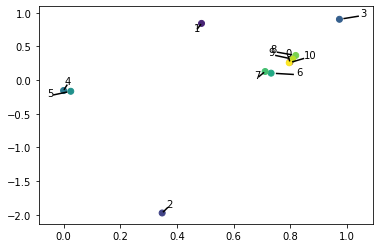

In [14]:
env.render()

In [ ]:
model_memory

In [ ]:
env.reset()

In [18]:
testenv = MultiEnv(BATCH_SIZE, MAX_ITER, device)

In [21]:
cobs = testenv.reset()
cmem, h = model_memory(cobs, None)
v_old = 0
r_sum = 0
for k in range(MAX_ITER):
    action = torch.tensor([k / (MAX_ITER-1)], dtype=torch.float, device=device).expand(BATCH_SIZE, 1)
    cobs, reward, _ = testenv.step(action)
    r_sum += reward.mean()
print(r_sum)

tensor(1.1408, device='cuda:0')


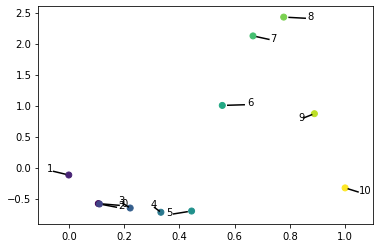

In [22]:
testenv.render()